In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
import pandas as pd
import numpy as np

In [2]:
spark

In [3]:
from pyspark.sql.functions import *

In [4]:
df = spark.read.option("delimiter", ",").csv("appl_accepted_20072019Q3.csv", header=True, inferSchema = True)

In [5]:
df.dtypes

[('id', 'string'),
 ('member_id', 'string'),
 ('loan_amnt', 'double'),
 ('funded_amnt', 'double'),
 ('funded_amnt_inv', 'double'),
 ('term', 'string'),
 ('int_rate', 'string'),
 ('installment', 'double'),
 ('grade', 'string'),
 ('sub_grade', 'string'),
 ('emp_title', 'string'),
 ('emp_length', 'string'),
 ('home_ownership', 'string'),
 ('annual_inc', 'string'),
 ('verification_status', 'string'),
 ('issue_d', 'string'),
 ('loan_status', 'string'),
 ('pymnt_plan', 'string'),
 ('url', 'string'),
 ('desc', 'string'),
 ('purpose', 'string'),
 ('title', 'string'),
 ('zip_code', 'string'),
 ('addr_state', 'string'),
 ('dti', 'string'),
 ('delinq_2yrs', 'string'),
 ('earliest_cr_line', 'string'),
 ('fico_range_low', 'string'),
 ('fico_range_high', 'string'),
 ('inq_last_6mths', 'string'),
 ('mths_since_last_delinq', 'string'),
 ('mths_since_last_record', 'string'),
 ('open_acc', 'string'),
 ('pub_rec', 'string'),
 ('revol_bal', 'string'),
 ('revol_util', 'string'),
 ('total_acc', 'string'),
 

checking for columns with lot of NULL values

In [6]:
from pyspark.sql.functions import isnan, when, count, col

nan_list = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])

In [7]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas().T

0
id                           0
member_id              2650550
loan_amnt                   33
funded_amnt                 33
funded_amnt_inv             33
...                        ...
settlement_status      2615950
settlement_date        2615955
settlement_amount      2615973
settlement_percentage  2615979
settlement_term        2615986

[150 rows x 1 columns]

NaN filter

In [8]:
# number of rows
row_count = df.count()

In [9]:
import pyspark.sql.functions as F

def drop_null_columns(df_orders):
    
    null_counts = df_orders.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_orders.columns]).collect()[0].asDict()
    to_drop = [k for k, v in null_counts.items() if v > row_count*0.6]
    df_orders = df_orders.drop(*to_drop)
    return df_orders

df_nan_filtered = drop_null_columns(df)

In [10]:
len(df_nan_filtered.columns)

108

Getting list of string and numeric columns

In [11]:
str_var = [i[0] for i in df_nan_filtered.dtypes if (i[1]=='string')]
num_var = [i[0] for i in df_nan_filtered.dtypes if ((i[1]=='int') | (i[1]=='double'))]
print('string features :',str_var)
print(len(str_var))
print(' ')
print('numerical features :',num_var)
print(len(num_var))

string features : ['id', 'term', 'int_rate', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc',

Counting number of unique elements in each columns

In [12]:
from pyspark.sql.functions import col, countDistinct

counts = df_nan_filtered.agg(*(countDistinct(col(c)).alias(c) for c in str_var))

In [13]:
counts.count()

1

In [14]:
len(counts.columns)

70

Sort all unique, many unique and some unique.

In [15]:
unique_str_features = []      # categories with unique strings
some_cat_features = []        # 100 categories threshold
many_cat_features = []        # between 100 and uniques

for i in counts.columns:
    print(i)
    decision1 = counts.select(counts[i] < 100).collect()[0]['('+i+' < 100)']
    decision2 = counts.select(counts[i] > row_count*0.85).collect()[0]['('+i+' > '+str(row_count*0.85)+')']
    if(decision1):
        print(' -> added to some')
        some_cat_features.append(i)
    elif(decision2):
        unique_str_features.append(i)
        print(' -> added to unique')
    else:
        many_cat_features.append(i)
        print(' -> added to many')
        
print(unique_str_features)
print(some_cat_features)
print(many_cat_features)

id
 -> added to unique
term
 -> added to some
int_rate
 -> added to many
grade
 -> added to some
sub_grade
 -> added to some
emp_title
 -> added to many
emp_length
 -> added to some
home_ownership
 -> added to some
annual_inc
 -> added to many
verification_status
 -> added to some
issue_d
 -> added to many
loan_status
 -> added to some
pymnt_plan
 -> added to some
url
 -> added to unique
purpose
 -> added to many
title
 -> added to many
zip_code
 -> added to many
addr_state
 -> added to many
dti
 -> added to many
delinq_2yrs
 -> added to many
earliest_cr_line
 -> added to many
fico_range_low
 -> added to many
fico_range_high
 -> added to many
inq_last_6mths
 -> added to many
mths_since_last_delinq
 -> added to many
open_acc
 -> added to many
pub_rec
 -> added to many
revol_bal
 -> added to many
revol_util
 -> added to many
total_acc
 -> added to many
initial_list_status
 -> added to many
out_prncp
 -> added to many
out_prncp_inv
 -> added to many
total_pymnt
 -> added to many
total_pym

check numeric in string columns

In [16]:
from pyspark.sql import functions as F

num_cat = []

for c in many_cat_features:
    col = df_nan_filtered.select(c,F.col(c).cast("double").isNotNull().alias("Value"))#.show()#.alias("Value")
    if(col.groupBy('value').count().orderBy('count', ascending=False).collect()[0]['value']):
        num_cat.append(c)

In [17]:
num_cat

['int_rate',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_amnt',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'tot_coll_amt',
 'tot_cur_bal',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'avg_cur_bal',
 'bc_util']

In [18]:
from pyspark.sql.functions import col

for c in num_cat:
    df_nan_filtered = df_nan_filtered.withColumn(c,col(c).cast('float'))

In [19]:
str_var = [i[0] for i in df_nan_filtered.dtypes if (i[1]=='string')]
num_var = [i[0] for i in df_nan_filtered.dtypes if ((i[1]=='int') | (i[1]=='double') | (i[1]=='float'))]
print('string features :',str_var)
print(len(str_var))
print(' ')
print('numerical features :',num_var)
print(len(num_var))

string features : ['id', 'term', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'purpose', 'title', 'zip_code', 'addr_state', 'earliest_cr_line', 'mths_since_last_delinq', 'initial_list_status', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'policy_code', 'application_type', 'acc_now_delinq', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'inq_fi', 'total_cu_tl', 'hardship_flag', 'debt_settlement_flag']
35
 
numerical features : ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'last_fico_rang

Anonymize dictionary

In [20]:
anonymize = {'url':'image_url' , 'zip_code':'postcode' ,'addr_state':'address'}
primary_key = "id"
sensitive_fields = ['zip_code','addr_state','url']

In [21]:
cat_features = []
cat_features = sensitive_fields + [primary_key] + some_cat_features
cat_features = list(set(cat_features))  # ignore repetation 
print(cat_features)
print(len(cat_features))

['url', 'hardship_flag', 'total_cu_tl', 'zip_code', 'pymnt_plan', 'loan_status', 'term', 'policy_code', 'open_act_il', 'home_ownership', 'open_il_24m', 'open_acc_6m', 'id', 'emp_length', 'addr_state', 'open_il_12m', 'open_rv_24m', 'application_type', 'verification_status', 'inq_fi', 'debt_settlement_flag', 'open_rv_12m', 'sub_grade', 'acc_now_delinq', 'grade']
25


In [22]:
features = cat_features + num_var
print(features)
df_final = df_nan_filtered.select([col for col in features])
df_final = df_final.na.drop() # drop null columns

['url', 'hardship_flag', 'total_cu_tl', 'zip_code', 'pymnt_plan', 'loan_status', 'term', 'policy_code', 'open_act_il', 'home_ownership', 'open_il_24m', 'open_acc_6m', 'id', 'emp_length', 'addr_state', 'open_il_12m', 'open_rv_24m', 'application_type', 'verification_status', 'inq_fi', 'debt_settlement_flag', 'open_rv_12m', 'sub_grade', 'acc_now_delinq', 'grade', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'tot_coll_amt', 'tot_cur_bal', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_last_12m', 'acc_ope

In [23]:
df_final = df_final.sample(0.003)

In [24]:
data = df_final.toPandas()

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2841 entries, 0 to 2840
Data columns (total 98 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   url                         2841 non-null   object 
 1   hardship_flag               2841 non-null   object 
 2   total_cu_tl                 2841 non-null   object 
 3   zip_code                    2841 non-null   object 
 4   pymnt_plan                  2841 non-null   object 
 5   loan_status                 2841 non-null   object 
 6   term                        2841 non-null   object 
 7   policy_code                 2841 non-null   object 
 8   open_act_il                 2841 non-null   object 
 9   home_ownership              2841 non-null   object 
 10  open_il_24m                 2841 non-null   object 
 11  open_acc_6m                 2841 non-null   object 
 12  id                          2841 non-null   object 
 13  emp_length                  2841 

In [26]:
from sdv.tabular import CTGAN
#model = CTGAN.load('my_model.pkl')

In [27]:
from sdv.tabular import CTGAN

model = CTGAN(cuda = True, verbose = True ,epochs=500,batch_size=100,generator_dim=(256, 256, 256),discriminator_dim=(256, 256, 256),primary_key =primary_key,anonymize_fields = anonymize)
model.fit(data)

/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for

/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in

/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in

/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional argum

/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in

Epoch 1, Loss G:  2.0767,Loss D: -0.2658
Epoch 2, Loss G:  2.4343,Loss D:  0.1936
Epoch 3, Loss G:  1.5820,Loss D:  0.3904
Epoch 4, Loss G:  1.8676,Loss D: -0.2111
Epoch 5, Loss G:  2.0523,Loss D: -0.9425
Epoch 6, Loss G:  1.1239,Loss D:  0.1572
Epoch 7, Loss G:  1.1089,Loss D:  0.1193
Epoch 8, Loss G:  0.9755,Loss D: -0.7083
Epoch 9, Loss G:  0.9104,Loss D:  0.1653
Epoch 10, Loss G:  0.4655,Loss D: -0.4107
Epoch 11, Loss G:  0.8680,Loss D:  0.6945
Epoch 12, Loss G: -0.0838,Loss D:  0.4485
Epoch 13, Loss G:  0.5317,Loss D:  0.0297
Epoch 14, Loss G: -0.6517,Loss D:  0.3580
Epoch 15, Loss G: -0.1570,Loss D: -0.8704
Epoch 16, Loss G: -1.0521,Loss D: -0.3237
Epoch 17, Loss G: -0.6835,Loss D: -0.5808
Epoch 18, Loss G: -1.6895,Loss D: -0.0411
Epoch 19, Loss G: -1.3215,Loss D:  1.6172
Epoch 20, Loss G: -1.8535,Loss D: -0.3475
Epoch 21, Loss G: -0.5665,Loss D: -0.1716
Epoch 22, Loss G: -0.8455,Loss D:  0.3241
Epoch 23, Loss G: -0.0271,Loss D:  0.2154
Epoch 24, Loss G: -1.3604,Loss D:  0.3332
E

Epoch 195, Loss G: -0.0241,Loss D:  0.5234
Epoch 196, Loss G: -0.3185,Loss D: -0.5431
Epoch 197, Loss G: -0.7892,Loss D:  2.2391
Epoch 198, Loss G: -0.0116,Loss D:  1.1064
Epoch 199, Loss G: -0.1415,Loss D:  0.9400
Epoch 200, Loss G: -0.8302,Loss D: -1.8183
Epoch 201, Loss G:  0.7154,Loss D: -0.5317
Epoch 202, Loss G: -0.5855,Loss D:  3.7468
Epoch 203, Loss G:  1.0455,Loss D:  0.1388
Epoch 204, Loss G: -0.9050,Loss D:  1.7041
Epoch 205, Loss G: -1.4275,Loss D:  1.6671
Epoch 206, Loss G: -0.1067,Loss D: -1.3012
Epoch 207, Loss G: -1.7307,Loss D: -0.1904
Epoch 208, Loss G:  1.1631,Loss D: -0.9489
Epoch 209, Loss G: -0.1703,Loss D:  1.0983
Epoch 210, Loss G: -0.6507,Loss D:  0.8969
Epoch 211, Loss G:  0.1709,Loss D: -1.7461
Epoch 212, Loss G: -2.4529,Loss D: -2.0899
Epoch 213, Loss G: -0.9440,Loss D: -2.2188
Epoch 214, Loss G: -0.5393,Loss D: -0.1335
Epoch 215, Loss G:  0.1147,Loss D:  1.2181
Epoch 216, Loss G: -1.2290,Loss D:  0.9042
Epoch 217, Loss G: -0.4185,Loss D:  2.3209
Epoch 218, 

Epoch 386, Loss G: -0.5588,Loss D:  1.1257
Epoch 387, Loss G: -1.3248,Loss D:  0.2385
Epoch 388, Loss G: -2.2753,Loss D:  0.9494
Epoch 389, Loss G:  1.1310,Loss D: -0.0067
Epoch 390, Loss G: -1.3720,Loss D: -2.0924
Epoch 391, Loss G:  0.5052,Loss D:  0.5340
Epoch 392, Loss G: -0.8060,Loss D: -0.7838
Epoch 393, Loss G:  0.1154,Loss D: -0.0558
Epoch 394, Loss G: -2.4450,Loss D:  1.2431
Epoch 395, Loss G:  0.4664,Loss D:  0.3133
Epoch 396, Loss G:  0.9418,Loss D: -2.4261
Epoch 397, Loss G: -2.1519,Loss D:  1.8328
Epoch 398, Loss G:  1.1946,Loss D:  0.2831
Epoch 399, Loss G: -0.3473,Loss D: -1.6941
Epoch 400, Loss G:  0.2053,Loss D:  1.7182
Epoch 401, Loss G:  0.9444,Loss D: -0.0264
Epoch 402, Loss G:  0.2163,Loss D: -0.3784
Epoch 403, Loss G: -1.0538,Loss D: -2.7829
Epoch 404, Loss G:  0.6991,Loss D:  0.7190
Epoch 405, Loss G:  0.8929,Loss D: -0.7644
Epoch 406, Loss G: -0.3261,Loss D: -1.8307
Epoch 407, Loss G: -0.0690,Loss D: -0.1737
Epoch 408, Loss G: -1.9476,Loss D: -1.3829
Epoch 409, 

In [28]:
model.save('my_model.pkl')

In [29]:
syn_data = model.sample(2841)
syn_data.head(20)

url hardship_flag total_cu_tl zip_code  \
0      https://placeimg.com/997/891/any             N         0.0    77486   
1       https://placekitten.com/313/124             N         0.0    43722   
2       https://placekitten.com/231/452             N         2.0    91477   
3    https://www.lorempixel.com/337/866             N         0.0    74606   
4         https://dummyimage.com/81x746             N         2.0    05924   
5     https://www.lorempixel.com/53/419             N         0.0    13942   
6       https://placekitten.com/262/640             N         4.0    05495   
7       https://placekitten.com/953/882             N         1.0    76148   
8       https://placekitten.com/839/695             N         0.0    57880   
9          https://dummyimage.com/22x90             N        14.0    21561   
10     https://placeimg.com/315/690/any             N         0.0    55718   
11     https://placeimg.com/331/522/any             N         1.0    51172   
12       https://placekitten.com/20/805             N         0.0    84021   
13       https://placeimg.com/81/49/any             N         0.0    01903   
14      https://placekitten.com/102/933             N         0.0    67756   
15   https://www.lorempixel.com/595/480             N         1.0    39386   
16       https://dummyimage.com/552x208             N         0.0    48603   
17   https://www.lorempixel.com/222/603             N         0.0    56033   
18  https://www.lorempixel.com/1017/516             N         0.0    70088   
19       https://dummyimage.com/388x562             N         4.0    58815   

   pymnt_plan  loan_status        term policy_code open_act_il home_ownership  \
0           n      Current   60 months         1.0         1.0       MORTGAGE   
1           n      Current   36 months         1.0         7.0            OWN   
2           n      Current   36 months         1.0         3.0       MORTGAGE   
3           n      Current   36 months         1.0         3.0       MORTGAGE   
4           n   Fully Paid   36 months         1.0         4.0           RENT   
5           n  Charged Off   60 months         1.0         1.0           RENT   
6           n      Current   36 months         1.0         1.0           RENT   
7           n      Current   36 months         1.0         2.0           RENT   
8           n   Fully Paid   60 months         1.0         2.0       MORTGAGE   
9           n      Current   60 months         1.0        13.0            OWN   
10          n      Current   36 months         1.0         2.0       MORTGAGE   
11          n      Current   36 months         1.0         3.0            OWN   
12          n      Current   36 months         1.0         1.0           RENT   
13          n      Current   36 months         1.0         1.0       MORTGAGE   
14          n      Current   36 months         1.0         2.0            OWN   
15          n      Current   60 months         1.0         9.0       MORTGAGE   
16          n      Current   36 months         1.0         3.0       MORTGAGE   
17          n      Current   36 months         1.0        11.0            OWN   
18          n      Current   60 months         1.0         3.0       MORTGAGE   
19          n      Current   36 months         1.0         3.0           RENT   

    ... num_tl_90g_dpd_24m num_tl_op_past_12m pct_tl_nvr_dlq percent_bc_gt_75  \
0   ...          -0.010073           4.351521     100.192970         0.899684   
1   ...           0.004171           5.579831      97.715389        71.585590   
2   ...           1.007728           0.918626      81.946722        61.285441   
3   ...           0.007485           0.992533      96.843419        37.780259   
4   ...           0.008645           3.062002      95.266986        -4.213163   
5   ...           0.012753           1.019233     100.578632        -1.084614   
6   ...          -0.014512          -0.040365      90.177196        -4.295279   
7   ...          -0.027573          -0.005062  

(2841, 98) (2912, 98)


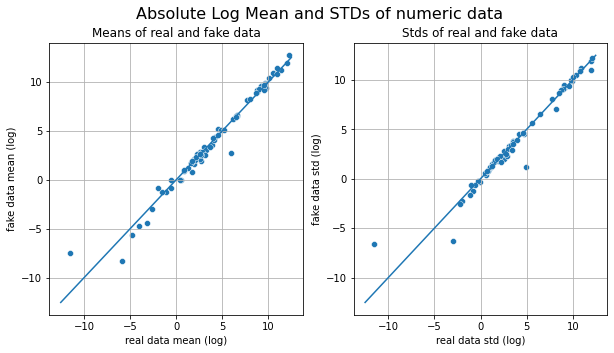

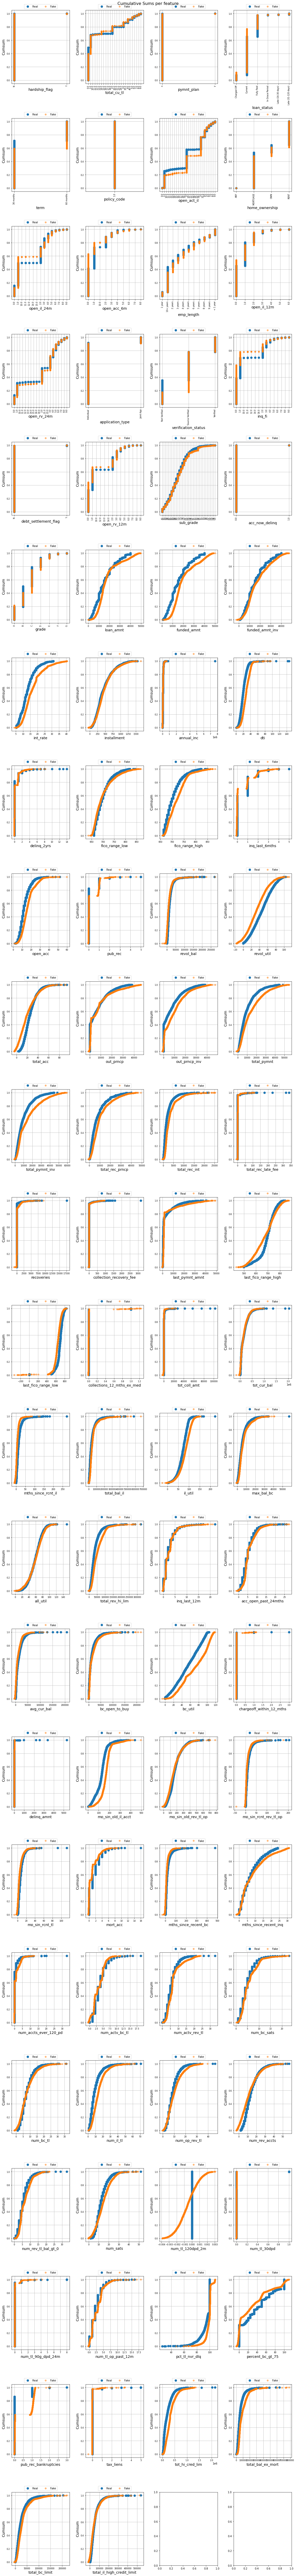

/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

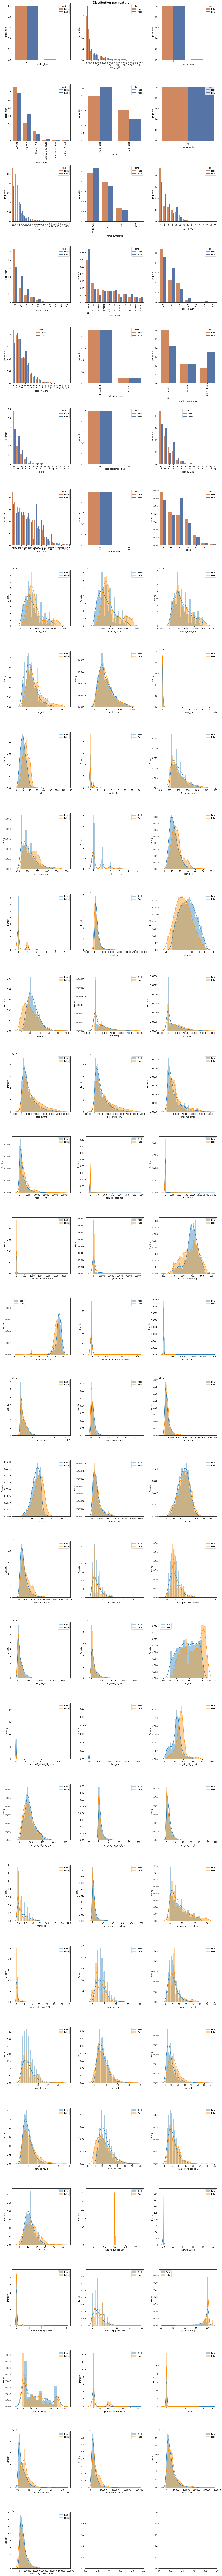

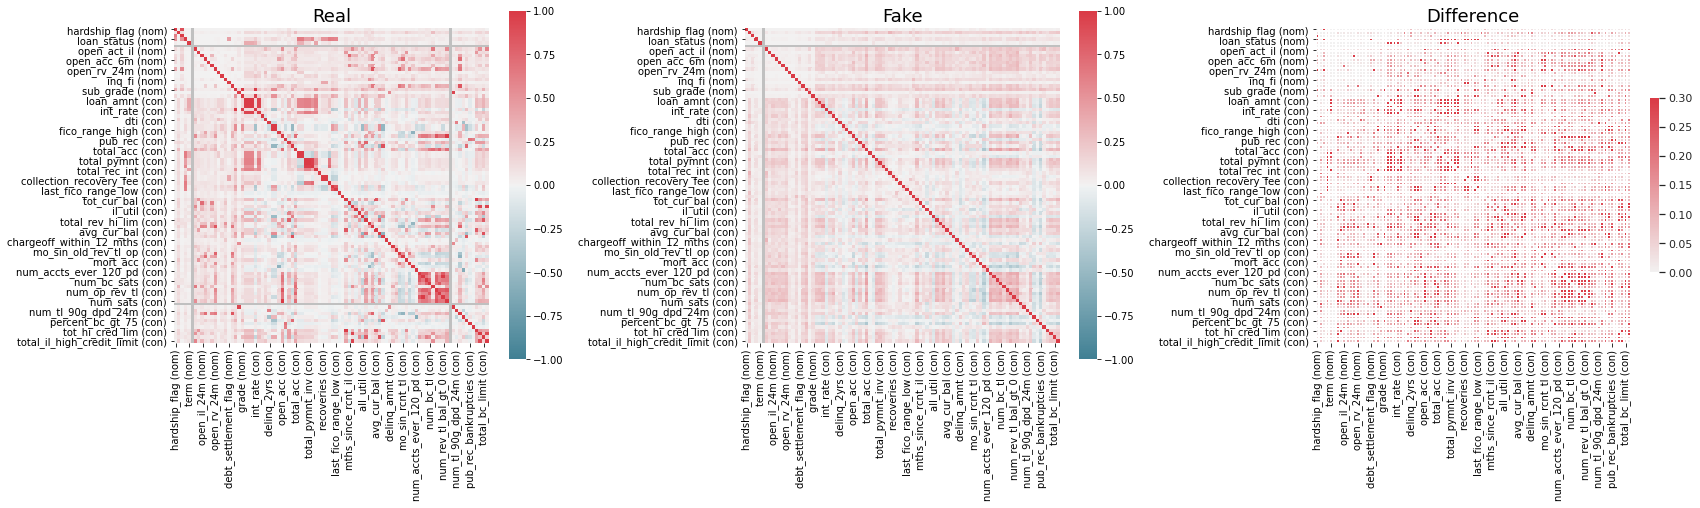

ValueError: Length of values (2841) does not match length of index (2910)

In [30]:
from table_evaluator import load_data, TableEvaluator

print(data.shape, syn_data.shape)
table_evaluator =  TableEvaluator(data.drop(sensitive_fields+[primary_key],axis = 1), syn_data.drop(sensitive_fields+[primary_key],axis = 1))

table_evaluator.visual_evaluation()

In [31]:
from sdv.evaluation import evaluate

evaluate(syn_data.drop(sensitive_fields+[primary_key],axis = 1), data.drop(sensitive_fields+[primary_key],axis = 1), metrics=['CSTest', 'KSTest'], aggregate=False)

metric                                     name  raw_score  \
0  CSTest                              Chi-Squared   0.970935   
1  KSTest  Inverted Kolmogorov-Smirnov D statistic   0.680467   

   normalized_score  min_value  max_value      goal  
0          0.970935        0.0        1.0  MAXIMIZE  
1          0.680467        0.0        1.0  MAXIMIZE

In [32]:
from sdv.tabular import TVAE

model_vae = TVAE(cuda = True,primary_key =primary_key,anonymize_fields = anonymize,epochs=500,compress_dims=(256, 256, 256),decompress_dims=(256, 256, 256))
model_vae.fit(data)

/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for

/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in

/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in

/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_ite

/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in

In [33]:
model_vae.save('my_model_vae.pkl')

In [34]:
syn_data_vae = model_vae.sample(2841)
syn_data_vae.head(20)

url hardship_flag total_cu_tl zip_code  \
0   https://www.lorempixel.com/1015/372             N         0.0    03955   
1        https://dummyimage.com/467x503             N         0.0    78688   
2        https://dummyimage.com/930x175             N         0.0    42154   
3     https://placeimg.com/1009/212/any             N         0.0    79039   
4    https://www.lorempixel.com/751/423             N         0.0    14658   
5    https://www.lorempixel.com/562/704             N         0.0    83765   
6        https://dummyimage.com/403x846             N         0.0    22241   
7      https://placeimg.com/534/288/any             N         0.0    76269   
8       https://dummyimage.com/738x1000             N         0.0    21523   
9      https://placeimg.com/457/622/any             N         0.0    37021   
10       https://placekitten.com/98/119             N         0.0    59662   
11     https://placeimg.com/614/688/any             N         0.0    88154   
12       https://dummyimage.com/912x438             N         0.0    65198   
13     https://placeimg.com/798/246/any             N         0.0    89680   
14      https://placekitten.com/898/841             N         0.0    94372   
15         https://dummyimage.com/6x938             N         0.0    03250   
16  https://www.lorempixel.com/440/1015             N         0.0    18958   
17      https://placekitten.com/352/171             N         0.0    38517   
18       https://dummyimage.com/156x425             N         0.0    89872   
19        https://dummyimage.com/13x339             N         0.0    27838   

   pymnt_plan  loan_status        term policy_code open_act_il home_ownership  \
0           n      Current   36 months         1.0         3.0           RENT   
1           n      Current   36 months         1.0         2.0       MORTGAGE   
2           n      Current   36 months         1.0         1.0           RENT   
3           n      Current   36 months         1.0         2.0       MORTGAGE   
4           n      Current   36 months         1.0         1.0           RENT   
5           n   Fully Paid   36 months         1.0         1.0       MORTGAGE   
6           n      Current   36 months         1.0         1.0           RENT   
7           n      Current   36 months         1.0         2.0       MORTGAGE   
8           n      Current   60 months         1.0         1.0           RENT   
9           n      Current   36 months         1.0         2.0       MORTGAGE   
10          n      Current   60 months         1.0         2.0           RENT   
11          n  Charged Off   60 months         1.0         1.0           RENT   
12          n      Current   36 months         1.0         3.0       MORTGAGE   
13          n      Current   60 months         1.0         1.0           RENT   
14          n      Current   36 months         1.0         2.0       MORTGAGE   
15          n  Charged Off   60 months         1.0         2.0       MORTGAGE   
16          n      Current   36 months         1.0         2.0       MORTGAGE   
17          n      Current   36 months         1.0         3.0       MORTGAGE   
18          n      Current   60 months         1.0         2.0       MORTGAGE   
19          n      Current   60 months         1.0         2.0           RENT   

    ... num_tl_90g_dpd_24m num_tl_op_past_12m pct_tl_nvr_dlq percent_bc_gt_75  \
0   ...          -0.000143           2.984473      99.562041        78.483344   
1   ...          -0.000695           2.953226      99.820893        77.297370   
2   ...          -0.000006           1.000807     100.101233        -1.978977   
3   ...           0.000051           1.989143      99.851000        -0.358873   
4   ...           0.000044           0.056926      99.899012         0.908693   
5   ...           0.000081           3.021720     100.078058         1.159164   
6   ...           0.001337           2.020885      99.998914        96.665288   
7   ...          -0.000489           1.975422  

(2841, 98) (2841, 98)


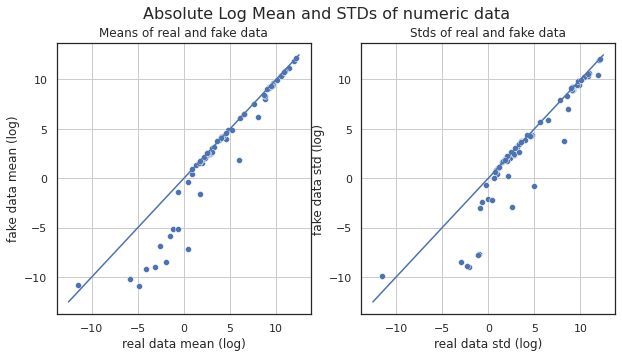

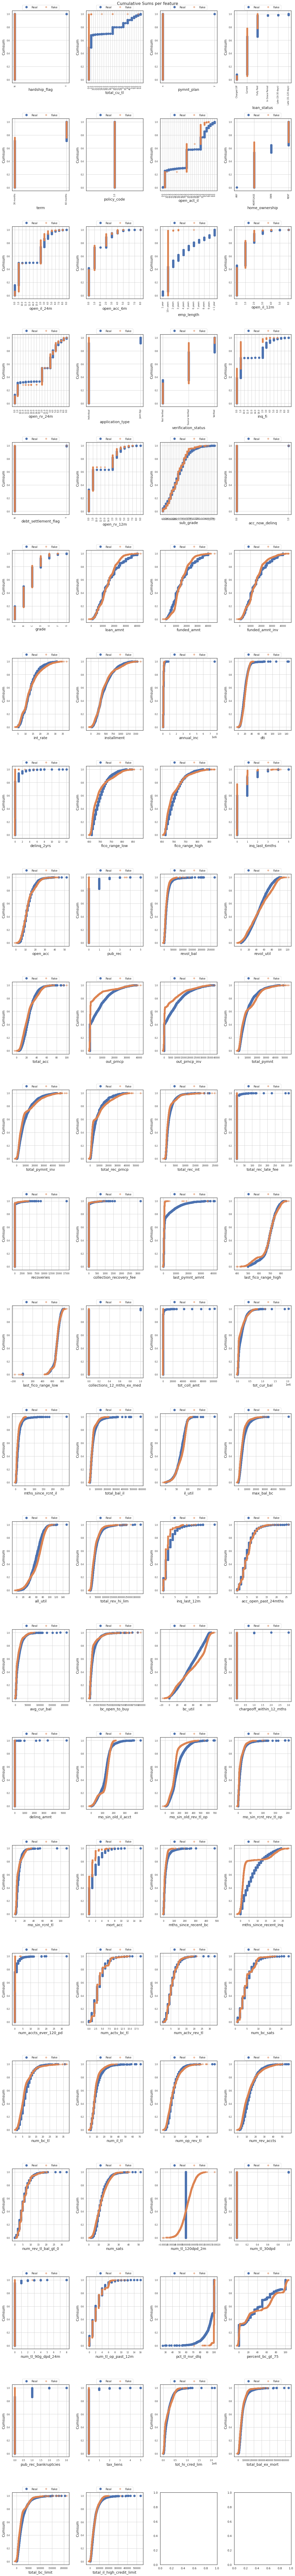

/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

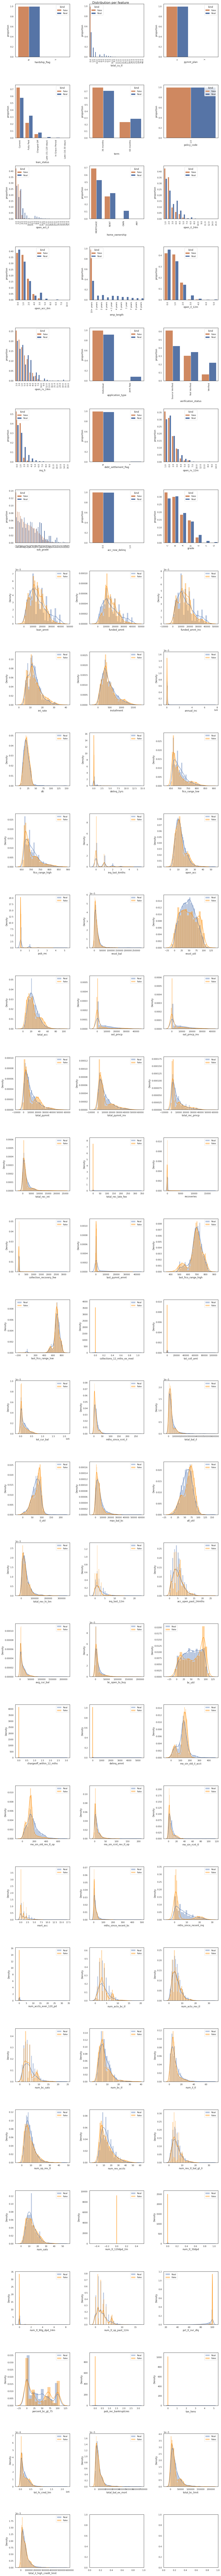

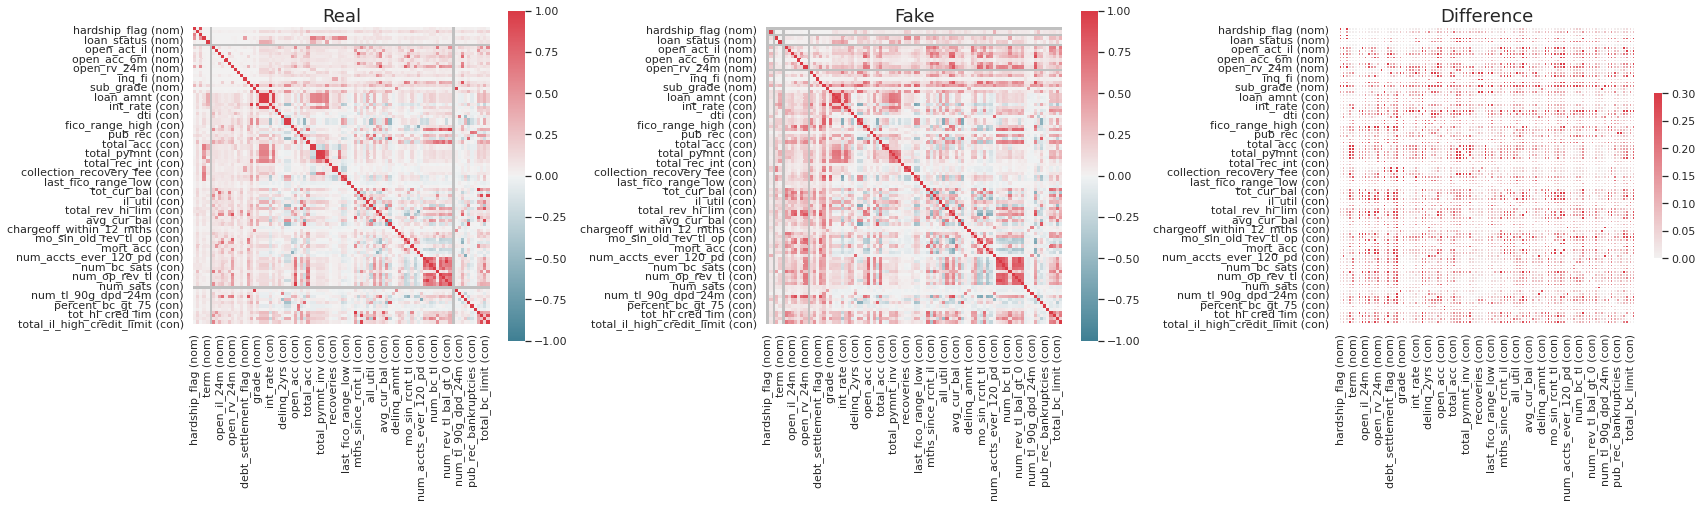

ValueError: cannot set a frame with no defined index and a scalar

In [35]:
from table_evaluator import load_data, TableEvaluator

print(data.shape, syn_data_vae.shape)
table_evaluator =  TableEvaluator(data.drop(sensitive_fields+[primary_key],axis = 1), syn_data_vae.drop(sensitive_fields+[primary_key],axis = 1))

table_evaluator.visual_evaluation()

In [36]:
from sdv.evaluation import evaluate

evaluate(syn_data_vae.drop(sensitive_fields+[primary_key],axis = 1), data.drop(sensitive_fields+[primary_key],axis = 1), metrics=['CSTest', 'KSTest'], aggregate=False)

metric                                     name  raw_score  \
0  CSTest                              Chi-Squared   0.971672   
1  KSTest  Inverted Kolmogorov-Smirnov D statistic   0.757841   

   normalized_score  min_value  max_value      goal  
0          0.971672        0.0        1.0  MAXIMIZE  
1          0.757841        0.0        1.0  MAXIMIZE

In [37]:
data = data.reindex(columns = features)
syn_data = syn_data.reindex(columns = features)
syn_data_vae = syn_data_vae.reindex(columns = features)

In [38]:
syn_f = pd.concat([syn_data,syn_data_vae])

mix both data

(2841, 98) (5753, 98)


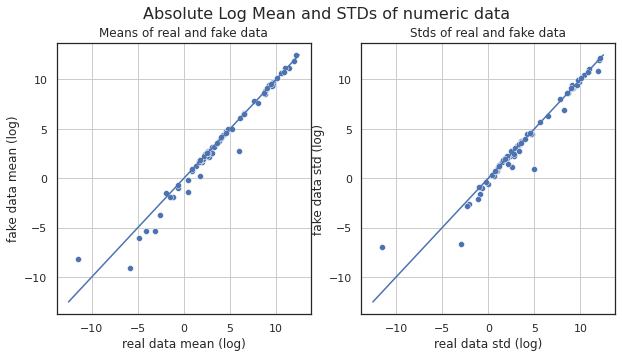

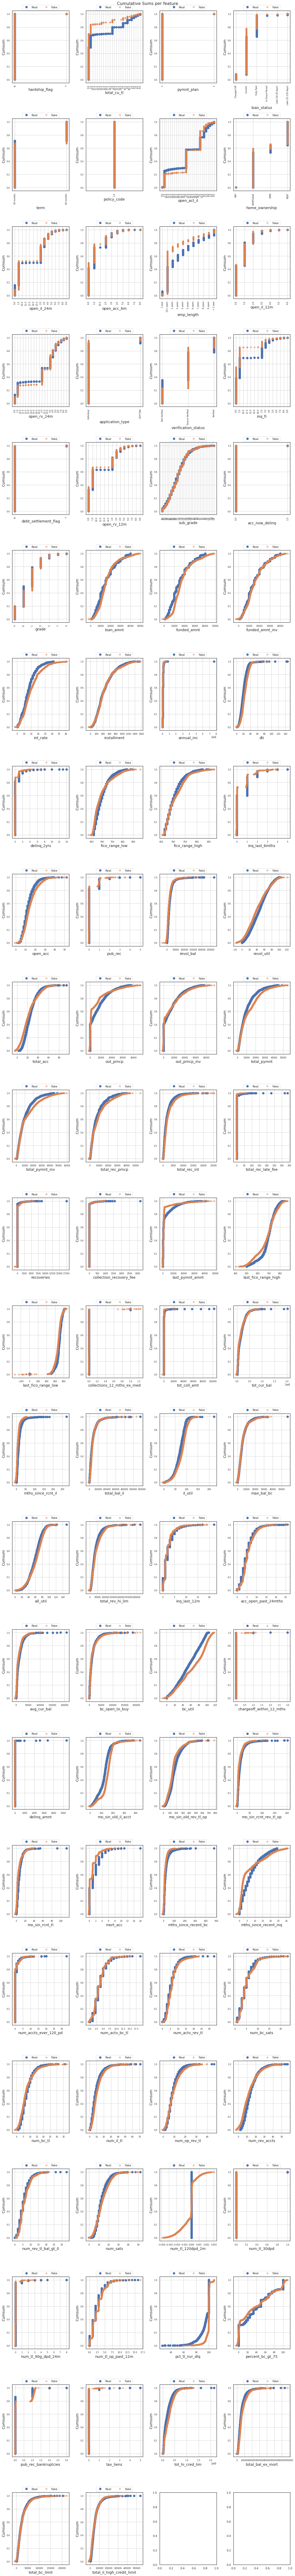

/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

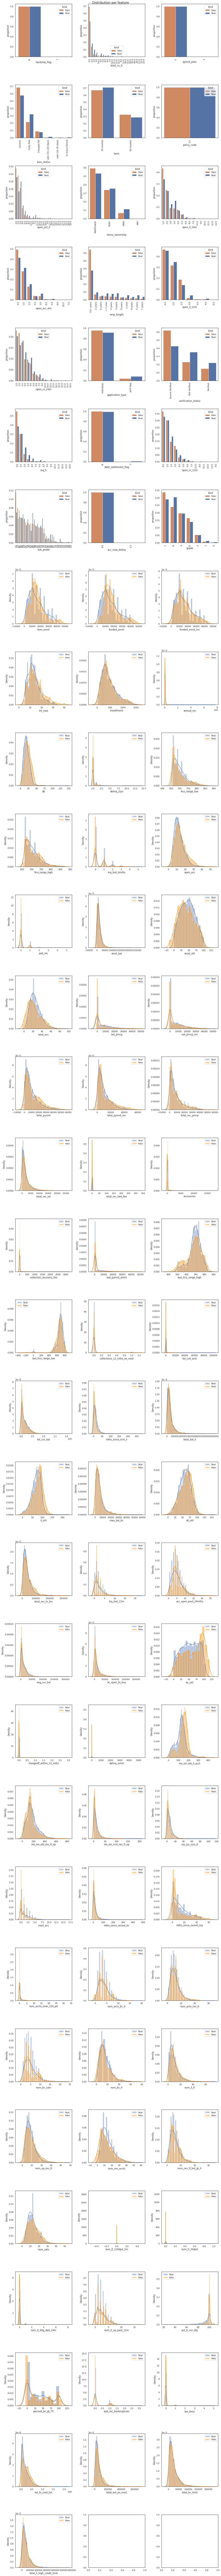

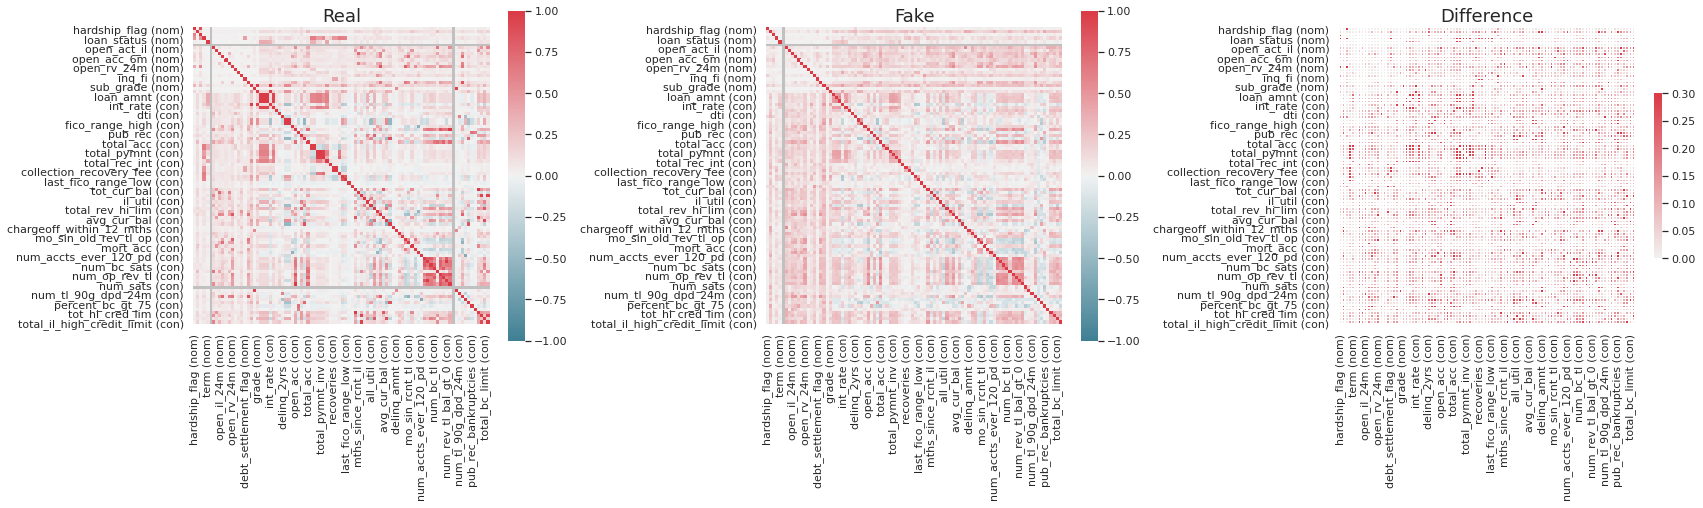

ValueError: Shape of passed values is (3566, 23), indices imply (2874, 23)

In [39]:
from table_evaluator import load_data, TableEvaluator

print(data.shape, syn_f.shape)
table_evaluator =  TableEvaluator(data.drop(sensitive_fields+[primary_key],axis = 1), syn_f.drop(sensitive_fields+[primary_key],axis = 1))

table_evaluator.visual_evaluation()

In [40]:
from sdv.evaluation import evaluate

evaluate(syn_f.drop(sensitive_fields+[primary_key],axis = 1), data.drop(sensitive_fields+[primary_key],axis = 1), metrics=['CSTest', 'KSTest'], aggregate=False)

metric                                     name  raw_score  \
0  CSTest                              Chi-Squared   0.979770   
1  KSTest  Inverted Kolmogorov-Smirnov D statistic   0.751906   

   normalized_score  min_value  max_value      goal  
0          0.979770        0.0        1.0  MAXIMIZE  
1          0.751906        0.0        1.0  MAXIMIZE

In [41]:
data['zip_code']

0       922xx
1       462xx
2       064xx
3       481xx
4       531xx
        ...  
2836    170xx
2837    350xx
2838    441xx
2839    197xx
2840    945xx
Name: zip_code, Length: 2841, dtype: object

In [42]:
syn_data['zip_code']

0       77486
1       43722
2       91477
3       74606
4       05924
        ...  
2907    71317
2908    68262
2909    10808
2910    64729
2911    77445
Name: zip_code, Length: 2912, dtype: object

In [43]:
data['url']

0       https://lendingclub.com/browse/loanDetail.acti...
1       https://lendingclub.com/browse/loanDetail.acti...
2       https://lendingclub.com/browse/loanDetail.acti...
3       https://lendingclub.com/browse/loanDetail.acti...
4       https://lendingclub.com/browse/loanDetail.acti...
                              ...                        
2836    https://lendingclub.com/browse/loanDetail.acti...
2837    https://lendingclub.com/browse/loanDetail.acti...
2838    https://lendingclub.com/browse/loanDetail.acti...
2839    https://lendingclub.com/browse/loanDetail.acti...
2840    https://lendingclub.com/browse/loanDetail.acti...
Name: url, Length: 2841, dtype: object

In [44]:
syn_data['url']

0         https://placeimg.com/997/891/any
1          https://placekitten.com/313/124
2          https://placekitten.com/231/452
3       https://www.lorempixel.com/337/866
4            https://dummyimage.com/81x746
                       ...                
2907        https://dummyimage.com/418x438
2908    https://www.lorempixel.com/189/331
2909       https://placekitten.com/130/806
2910      https://placeimg.com/752/641/any
2911       https://placekitten.com/217/323
Name: url, Length: 2912, dtype: object

In [45]:
data['home_ownership']

0           RENT
1       MORTGAGE
2           RENT
3       MORTGAGE
4       MORTGAGE
          ...   
2836    MORTGAGE
2837    MORTGAGE
2838    MORTGAGE
2839    MORTGAGE
2840        RENT
Name: home_ownership, Length: 2841, dtype: object

In [46]:
syn_data['home_ownership']

0       MORTGAGE
1            OWN
2       MORTGAGE
3       MORTGAGE
4           RENT
          ...   
2907    MORTGAGE
2908        RENT
2909    MORTGAGE
2910         OWN
2911    MORTGAGE
Name: home_ownership, Length: 2912, dtype: object

In [ ]:
#df_nan_filtered.select(['revol_bal']).show()

In [ ]:
#spark.stop()

Substitution with fake data

In [ ]:
#df_nan_filtered.select(['addr_state']).show()

In [ ]:
'''from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from faker import Factory

def fake_name():
    faker = Factory.create()
    return faker.address()

fake_name_udf = udf(fake_name, StringType())
df_anon = df_nan_filtered.withColumn('addr_state', fake_name_udf())'''

In [ ]:
#df_anon.select(['addr_state']).show()